# K-Means Clustering Analysis
## Pengeluaran Perkapita Buah-buahan dan Sayur-sayuran per Kabupaten/Kota

---

### 🎯 **Tujuan Analisis**

Mengelompokkan kabupaten/kota di Indonesia berdasarkan pola pengeluaran untuk buah-buahan dan sayur-sayuran menggunakan **K-Means Clustering**.

### 📊 **Dataset**
- Source: Data cleaned dari preprocessing
- Features: Pengeluaran berbagai jenis buah dan sayur
- Observations: 514 Kabupaten/Kota × 2 Tahun

### 🔬 **Metode**
1. **Data Preparation**: Load dan prepare data untuk clustering
2. **Feature Selection**: Pilih fitur yang relevan
3. **Scaling**: Normalisasi data
4. **K-Means Clustering**: Pengelompokan data
5. **Evaluation**: Silhouette Score untuk validasi

---

### 📈 **Expected Outcomes**
- Identifikasi kelompok kabupaten dengan pola konsumsi serupa
- Insights tentang disparitas pengeluaran regional
- Rekomendasi policy berdasarkan cluster

## 1. Import Libraries

**Tujuan**: Memuat library yang diperlukan untuk clustering dan evaluasi.

**Libraries**:
- `pandas`, `numpy`: Data manipulation
- `sklearn`: Machine learning algorithms
- `matplotlib`, `seaborn`: Visualisasi
- `warnings`: Suppress warnings

In [33]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Data

**Tujuan**: Memuat data yang sudah dibersihkan dari tahap preprocessing.

**File yang digunakan**: `data_integrated_long.csv`
- Format long (tidy data) lebih fleksibel untuk analisis
- Akan di-transform ke semi-wide untuk clustering

**Strategi**:
1. Load data long format
2. Filter baris dengan `Is_Total = True` → hanya total pengeluaran Buah & Sayur per wilayah
3. Pivot untuk mendapatkan feature matrix: Pengeluaran_Buah dan Pengeluaran_Sayur
4. Filter untuk tahun 2024 (data terbaru)

In [34]:
# Load data long format
data_path = Path('data/cleaned/data_integrated_long.csv')

df_long = pd.read_csv(data_path)

print("="*60)
print("DATASET LOADED (Long Format)")
print("="*60)
print(f"Shape: {df_long.shape}")
print(f"Columns: {df_long.columns.tolist()}")

# Check unique values
print(f"\nYears available: {sorted(df_long['Tahun'].unique())}")
print(f"Total Kabupaten/Kota: {df_long['Kabupaten_Kota'].nunique()}")
print(f"Unique products: {df_long['Produk'].nunique()}")
print(f"Is_Total values: {df_long['Is_Total'].unique()}")

print("\nSample data:")
df_long.head(10)

DATASET LOADED (Long Format)
Shape: (44204, 10)
Columns: ['Kabupaten_Kota', 'Tahun', 'Kategori', 'Produk', 'Pengeluaran', 'Is_Total', 'Region', 'Kategori_Pengeluaran', 'Pengeluaran_Bulanan', 'Pengeluaran_Tahunan']

Years available: [np.int64(2023), np.int64(2024)]
Total Kabupaten/Kota: 514
Unique products: 43
Is_Total values: [ True False]

Sample data:


,Kabupaten_Kota,Tahun,Kategori,Produk,Pengeluaran,Is_Total,Region,Kategori_Pengeluaran,Pengeluaran_Bulanan,Pengeluaran_Tahunan
0,Simeulue,2023,Buah,BUAH-BUAHAN,5287.59,True,Lainnya,Sangat Tinggi,21150.36,274954.68
1,Aceh Singkil,2023,Buah,BUAH-BUAHAN,7377.18,True,Aceh,Sangat Tinggi,29508.72,383613.36
2,Aceh Selatan,2023,Buah,BUAH-BUAHAN,4589.20,True,Aceh,Sangat Tinggi,18356.80,238638.40
3,Aceh Tenggara,2023,Buah,BUAH-BUAHAN,5381.60,True,Aceh,Sangat Tinggi,21526.40,279843.20
4,Aceh Timur,2023,Buah,BUAH-BUAHAN,5630.94,True,Aceh,Sangat Tinggi,22523.76,292808.88
5,Aceh Tengah,2023,Buah,BUAH-BUAHAN,10500.46,True,Aceh,Sangat Tinggi,42001.84,546023.92
6,Aceh Barat,2023,Buah,BUAH-BUAHAN,9451.44,True,Aceh,Sangat Tinggi,37805.76,491474.88
7,Aceh Besar,2023,Buah,BUAH-BUAHAN,5480.57,True,Aceh,Sangat Tinggi,21922.28,284989.64
8,Pidie,2023,Buah,BUAH-BUAHAN,5716.10,True,Lainnya,Sangat Tinggi,22864.40,297237.20
9,Bireuen,2023,Buah,BUAH-BUAHAN,7543.48,True,Lainnya,Sangat Tinggi,30173.92,392260.96


## 3. Data Preparation & Pivot ke Semi-Wide Format

**Tujuan**: Transform data long → semi-wide untuk clustering.

**Langkah-langkah**:
1. **Filter `Is_Total = True`**: Ambil hanya total pengeluaran Buah & Sayur (bukan detail per komoditas)
2. **Filter tahun 2024**: Fokus pada data terbaru
3. **Pivot data**: Transform menjadi:
   - 1 baris = 1 Kabupaten/Kota
   - Kolom fitur: `Pengeluaran_Buah`, `Pengeluaran_Sayur`
4. **Handle missing values**: Pastikan data lengkap

**Output**: Feature matrix dengan 2 fitur agregat (lebih mudah diinterpretasi dibanding 43 fitur detail)

In [35]:
# Step 1: Filter data dengan Is_Total = True dan Tahun = 2024
df_total = df_long[(df_long['Is_Total'] == True) & (df_long['Tahun'] == 2024)].copy()

print("Step 1: Filter Is_Total = True & Tahun = 2024")
print(f"  Total rows after filter: {len(df_total)}")
print(f"  Kabupaten/Kota: {df_total['Kabupaten_Kota'].nunique()}")
print(f"  Unique Kategori: {df_total['Kategori'].unique()}")

# Step 2: Pivot untuk mendapatkan Pengeluaran_Buah dan Pengeluaran_Sayur
df_pivot = df_total.pivot_table(
    index=['Kabupaten_Kota', 'Tahun', 'Region'],
    columns='Kategori',
    values='Pengeluaran',
    aggfunc='first'
).reset_index()

# Rename kolom untuk clarity
df_pivot.columns.name = None  # Remove multi-level column name
df_pivot.rename(columns={'Buah': 'Pengeluaran_Buah', 'Sayur': 'Pengeluaran_Sayur'}, inplace=True)

print("\nStep 2: Pivot to Semi-Wide Format")
print(f"  Shape: {df_pivot.shape}")
print(f"  Columns: {df_pivot.columns.tolist()}")

# Step 3: Handle missing values
df_pivot = df_pivot.fillna(0)

print(f"\nStep 3: Handle Missing Values")
print(f"  Missing values: {df_pivot.isnull().sum().sum()}")

# Step 4: Extract feature matrix
feature_cols = ['Pengeluaran_Buah', 'Pengeluaran_Sayur']
X = df_pivot[feature_cols].copy()

print("\n" + "="*60)
print("DATA PREPARATION COMPLETE")
print("="*60)
print(f"✓ Feature matrix shape: {X.shape}")
print(f"✓ Features: {feature_cols}")
print(f"✓ Total Kabupaten/Kota: {len(df_pivot)}")
print("\nSample feature matrix:")
print(df_pivot[['Kabupaten_Kota', 'Region'] + feature_cols].head(10))

Step 1: Filter Is_Total = True & Tahun = 2024
  Total rows after filter: 1028
  Kabupaten/Kota: 514
  Unique Kategori: ['Buah' 'Sayur']

Step 2: Pivot to Semi-Wide Format
  Shape: (514, 5)
  Columns: ['Kabupaten_Kota', 'Tahun', 'Region', 'Pengeluaran_Buah', 'Pengeluaran_Sayur']

Step 3: Handle Missing Values
  Missing values: 0

DATA PREPARATION COMPLETE
✓ Feature matrix shape: (514, 2)
✓ Features: ['Pengeluaran_Buah', 'Pengeluaran_Sayur']
✓ Total Kabupaten/Kota: 514

Sample feature matrix:
    Kabupaten_Kota Region  Pengeluaran_Buah  Pengeluaran_Sayur
0       Aceh Barat   Aceh           11160.0            15821.0
1  Aceh Barat Daya   Aceh            7231.0            13790.0
2       Aceh Besar   Aceh            6689.0            14052.0
3        Aceh Jaya   Aceh            8789.0            14197.0
4     Aceh Selatan   Aceh            5682.0            14771.0
5     Aceh Singkil   Aceh            6363.0            17920.0
6     Aceh Tamiang   Aceh            7426.0            14233.0


## 4. Feature Scaling

**Tujuan**: Normalisasi fitur agar memiliki skala yang sama.

**Mengapa Scaling Penting untuk K-Means**:
- K-Means menggunakan **Euclidean distance** untuk menghitung jarak
- Pengeluaran Buah dan Sayur mungkin memiliki range yang berbeda
- Scaling memastikan kedua fitur memiliki kontribusi yang seimbang

**Metode**: StandardScaler (Z-score normalization)
- Formula: `z = (x - μ) / σ`
- Hasil: Mean = 0, Standard Deviation = 1
- Semua fitur menjadi comparable

**Keuntungan**:
✅ Fair comparison antar fitur (Buah vs Sayur)
✅ Improved clustering performance
✅ Faster convergence
✅ Interpretasi cluster lebih mudah

In [36]:
# Initialize scaler
scaler = StandardScaler()

# Fit dan transform data
X_scaled = scaler.fit_transform(X)

# Convert ke DataFrame untuk analisis
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

print("="*60)
print("FEATURE SCALING COMPLETE")
print("="*60)

print(f"\nOriginal data statistics:")
print(f"  Pengeluaran_Buah  → Mean: Rp {X['Pengeluaran_Buah'].mean():,.0f}, Std: Rp {X['Pengeluaran_Buah'].std():,.0f}")
print(f"  Pengeluaran_Sayur → Mean: Rp {X['Pengeluaran_Sayur'].mean():,.0f}, Std: Rp {X['Pengeluaran_Sayur'].std():,.0f}")
print(f"  Range: Rp {X.min().min():.0f} - Rp {X.max().max():,.0f}")

print(f"\nScaled data statistics:")
print(f"  Pengeluaran_Buah  → Mean: {X_scaled_df['Pengeluaran_Buah'].mean():.6f}, Std: {X_scaled_df['Pengeluaran_Buah'].std():.6f}")
print(f"  Pengeluaran_Sayur → Mean: {X_scaled_df['Pengeluaran_Sayur'].mean():.6f}, Std: {X_scaled_df['Pengeluaran_Sayur'].std():.6f}")
print(f"  Range: {X_scaled_df.min().min():.2f} - {X_scaled_df.max().max():.2f}")

print("\n✓ Data berhasil dinormalisasi!")
print("✓ Mean ≈ 0, Std ≈ 1 untuk kedua fitur")

FEATURE SCALING COMPLETE

Original data statistics:
  Pengeluaran_Buah  → Mean: Rp 9,293, Std: Rp 3,283
  Pengeluaran_Sayur → Mean: Rp 14,895, Std: Rp 6,587
  Range: Rp 1395 - Rp 81,168

Scaled data statistics:
  Pengeluaran_Buah  → Mean: -0.000000, Std: 1.000974
  Pengeluaran_Sayur → Mean: 0.000000, Std: 1.000974
  Range: -2.41 - 10.07

✓ Data berhasil dinormalisasi!
✓ Mean ≈ 0, Std ≈ 1 untuk kedua fitur


## 5. Determine Optimal Number of Clusters

**Tujuan**: Mencari jumlah cluster (k) yang optimal.

**Metode yang digunakan**:

### 5.1 Elbow Method
- Plot **Inertia** (Within-Cluster Sum of Squares) vs k
- Cari "elbow" (titik dimana penurunan inertia mulai landai)
- Inertia mengukur compactness dalam cluster

### 5.2 Silhouette Method
- Plot **Silhouette Score** vs k
- Score range: [-1, 1]
  - **1**: Perfect clustering
  - **0**: Overlapping clusters
  - **-1**: Wrong clustering
- Pilih k dengan silhouette score tertinggi

**Range k yang ditest**: 2 sampai 10 clusters

**Interpretasi**:
- Elbow: Balance antara complexity dan performance
- Silhouette: Measure of separation dan cohesion

In [37]:
k_range = range(2, 11)

# Store metrics
inertias = []
silhouette_scores = []

print("Testing different values of k...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    sil_score = silhouette_score(X_scaled, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(sil_score)
    
    print(f"k={k:2d} | Inertia: {inertia:>10.2f} | Silhouette: {sil_score:.4f}")

print("✓ Evaluation complete!")

Testing different values of k...
k= 2 | Inertia:     677.59 | Silhouette: 0.3965
k= 3 | Inertia:     434.77 | Silhouette: 0.4108
k= 4 | Inertia:     338.37 | Silhouette: 0.3812
k= 5 | Inertia:     272.08 | Silhouette: 0.3554k= 5 | Inertia:     272.08 | Silhouette: 0.3554

k= 6 | Inertia:     216.23 | Silhouette: 0.3627
k= 7 | Inertia:     184.07 | Silhouette: 0.3462
k= 8 | Inertia:     162.46 | Silhouette: 0.3509
k= 9 | Inertia:     143.81 | Silhouette: 0.3607
k= 6 | Inertia:     216.23 | Silhouette: 0.3627
k= 7 | Inertia:     184.07 | Silhouette: 0.3462
k= 8 | Inertia:     162.46 | Silhouette: 0.3509
k= 9 | Inertia:     143.81 | Silhouette: 0.3607
k=10 | Inertia:     124.77 | Silhouette: 0.3583
✓ Evaluation complete!
k=10 | Inertia:     124.77 | Silhouette: 0.3583
✓ Evaluation complete!


### 5.3 Visualisasi: Elbow & Silhouette Plots

**Interpretasi**:

**Elbow Plot (kiri)**:
- Sumbu X: Jumlah cluster (k)
- Sumbu Y: Inertia (WCSS)
- Cari "siku" dimana kurva mulai mendatar
- Trade-off: Complexity vs Performance

**Silhouette Plot (kanan)**:
- Sumbu X: Jumlah cluster (k)
- Sumbu Y: Silhouette Score
- Pilih k dengan score tertinggi
- Score > 0.5 = Good clustering
- Score > 0.7 = Strong clustering

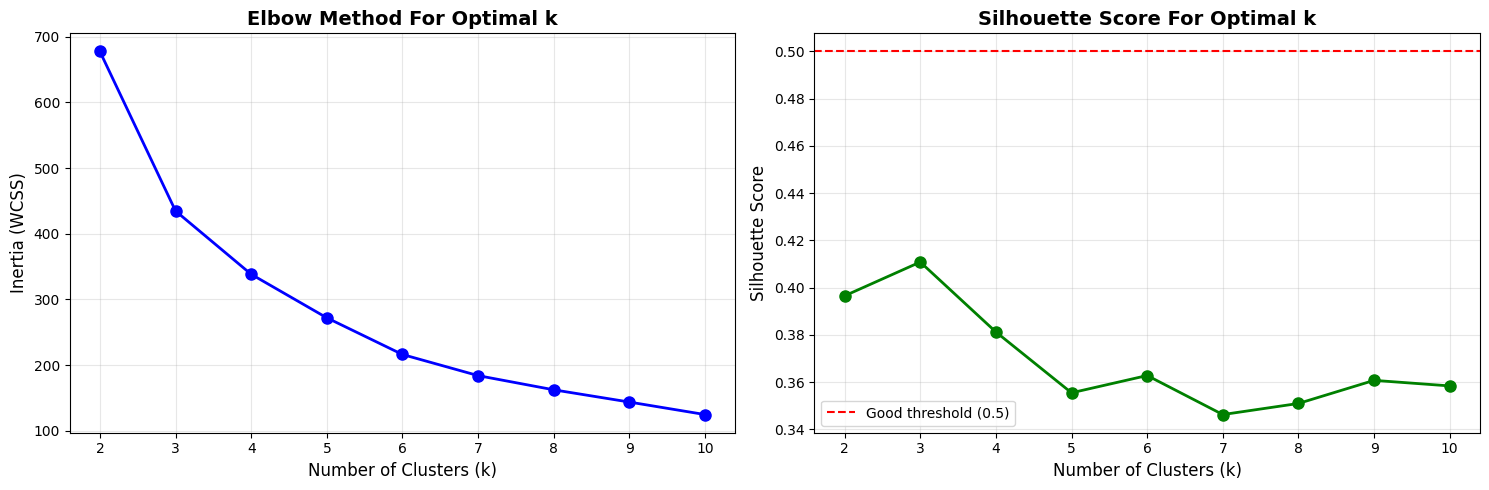

RECOMMENDATION
Optimal k (by Silhouette): 3
Max Silhouette Score: 0.4108


In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Elbow Method
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (WCSS)', fontsize=12)
axes[0].set_title('Elbow Method For Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Plot 2: Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score For Optimal k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Good threshold (0.5)')
axes[1].legend()

plt.tight_layout()
plt.show()

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
max_silhouette = max(silhouette_scores)

print("RECOMMENDATION")
print(f"Optimal k (by Silhouette): {optimal_k_silhouette}")
print(f"Max Silhouette Score: {max_silhouette:.4f}")

## 6. K-Means Clustering dengan Optimal K

**Tujuan**: Melatih model K-Means dengan jumlah cluster optimal.

**Parameter K-Means**:
- `n_clusters`: Jumlah cluster (dari analisis sebelumnya)
- `random_state=42`: Untuk reproducibility
- `n_init=10`: Jumlah inisialisasi dengan centroid berbeda
- `max_iter=300`: Maksimal iterasi

**Proses K-Means**:
1. **Initialization**: Random pilih k centroid
2. **Assignment**: Assign setiap data point ke centroid terdekat
3. **Update**: Hitung ulang centroid berdasarkan mean cluster
4. **Repeat**: Ulangi 2-3 sampai konvergen

**Output**:
- Label cluster untuk setiap kabupaten
- Centroid final
- Inertia final

In [39]:
optimal_k = optimal_k_silhouette

print(f"Training K-Means with k= {optimal_k}")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Model metrics
final_inertia = kmeans_final.inertia_
final_silhouette = silhouette_score(X_scaled, cluster_labels)

print("MODEL TRAINING COMPLETE")
print(f"Number of clusters: {optimal_k}")
print(f"Iterations to converge: {kmeans_final.n_iter_}")
print(f"Final inertia: {final_inertia:.2f}")
print(f"Final silhouette score: {final_silhouette:.4f}")

df_pivot['Cluster'] = cluster_labels

print("\nCluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"Cluster {cluster}: {count:3d} kabupaten ({percentage:5.2f}%)")

print("\n✓ Clustering complete!")

Training K-Means with k= 3
MODEL TRAINING COMPLETE
Number of clusters: 3
Iterations to converge: 7
Final inertia: 434.77
Final silhouette score: 0.4108

Cluster Distribution:
Cluster 0: 209 kabupaten (40.66%)
Cluster 1: 298 kabupaten (57.98%)
Cluster 2:   7 kabupaten ( 1.36%)

✓ Clustering complete!


## 7. Model Evaluation - Silhouette Analysis

**Tujuan**: Evaluasi detail kualitas clustering menggunakan Silhouette Score.

**Silhouette Score Explained**:
- **Formula**: `s(i) = (b(i) - a(i)) / max(a(i), b(i))`
  - `a(i)`: Rata-rata jarak dalam cluster (intra-cluster)
  - `b(i)`: Rata-rata jarak ke cluster terdekat (inter-cluster)

**Interpretasi Score**:
- **0.71 - 1.0**: Strong structure (excellent)
- **0.51 - 0.70**: Reasonable structure (good)
- **0.26 - 0.50**: Weak structure (fair)
- **< 0.26**: No substantial structure (poor)

**Visualisasi**:
- Silhouette plot menampilkan score untuk setiap data point
- Lebar bar = jumlah data points dalam cluster
- Red line = average silhouette score

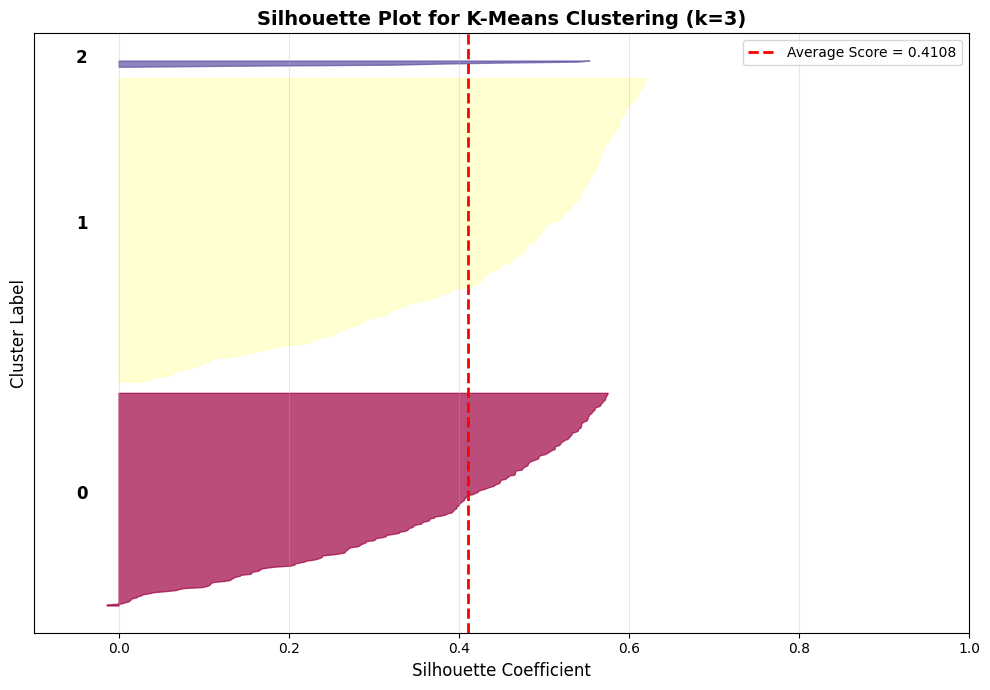

SILHOUETTE ANALYSIS
Overall Silhouette Score: 0.4108

Per-Cluster Silhouette Scores:
Cluster 0: 0.3697
Cluster 1: 0.4413
Cluster 2: 0.3418


In [40]:
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

fig, ax = plt.subplots(figsize=(10, 7))

y_lower = 10
colors = plt.cm.Spectral(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), 
            fontsize=12, fontweight='bold')
    
    y_lower = y_upper + 10

ax.set_title(f'Silhouette Plot for K-Means Clustering (k={optimal_k})', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster Label', fontsize=12)

ax.axvline(x=final_silhouette, color="red", linestyle="--", linewidth=2,
           label=f'Average Score = {final_silhouette:.4f}')

ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("SILHOUETTE ANALYSIS")
print(f"Overall Silhouette Score: {final_silhouette:.4f}")
print(f"\nPer-Cluster Silhouette Scores:")

for i in range(optimal_k):
    cluster_silhouette = sample_silhouette_values[cluster_labels == i].mean()
    print(f"Cluster {i}: {cluster_silhouette:.4f}")

## 8. Cluster Visualization: Scatter Plot Buah vs Sayur

**Tujuan**: Visualisasi cluster dalam 2D natural (tanpa PCA).

**Keuntungan dengan 2 Fitur**:
- Visualisasi langsung dengan sumbu **Pengeluaran_Buah** vs **Pengeluaran_Sayur**
- Tidak perlu dimensionality reduction (PCA)
- **Interpretasi lebih mudah** - sumbu adalah fitur asli, bukan komponen abstrak

**Interpretasi Plot**:
- **X-axis**: Pengeluaran Buah-buahan (Rp/minggu)
- **Y-axis**: Pengeluaran Sayur-sayuran (Rp/minggu)
- **Warna**: Menunjukkan cluster yang berbeda
- **Centroid**: Marker besar (⭐) menunjukkan pusat cluster

**Pola yang dicari**:
- Cluster di kanan atas = Tinggi pengeluaran Buah & Sayur
- Cluster di kiri bawah = Rendah pengeluaran Buah & Sayur
- - Cluster diagonal = Preferensi ke salah satu kategori

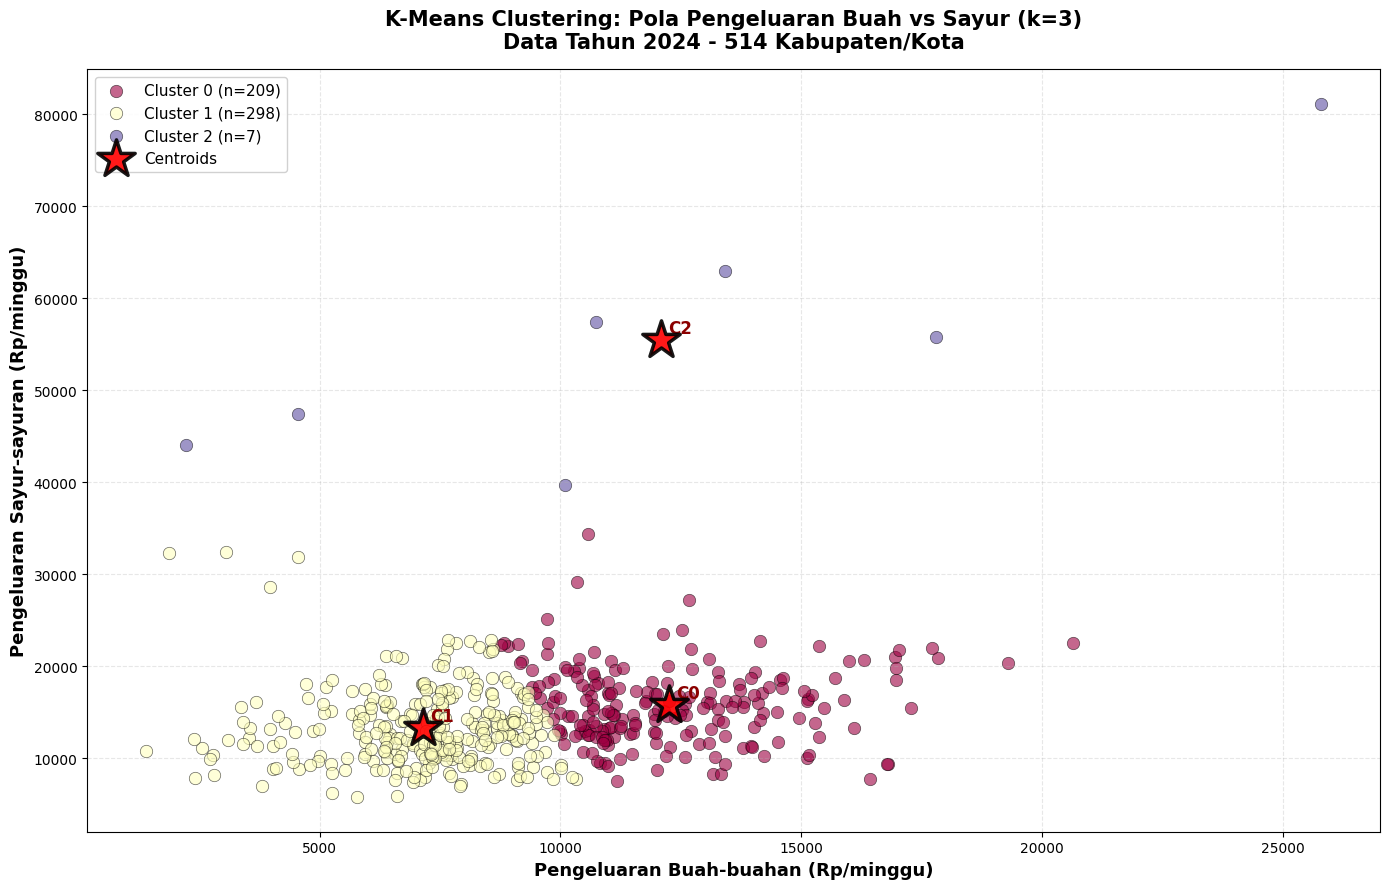

CLUSTER VISUALIZATION COMPLETE
✓ Plot: Pengeluaran Buah (X-axis) vs Sayur (Y-axis)
✓ Clusters: 3
✓ Data points: 514


In [41]:
# Prepare data for plotting (gunakan data asli, bukan scaled)
df_plot = df_pivot.copy()
df_plot['Cluster'] = cluster_labels

# Get centroids dalam nilai asli (inverse transform)
centroids_original = scaler.inverse_transform(kmeans_final.cluster_centers_)

# Create scatter plot
plt.figure(figsize=(14, 9))

# Plot each cluster
colors = plt.cm.Spectral(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_data = df_plot[df_plot['Cluster'] == i]
    plt.scatter(cluster_data['Pengeluaran_Buah'], 
                cluster_data['Pengeluaran_Sayur'],
                c=[colors[i]], 
                label=f'Cluster {i} (n={len(cluster_data)})',
                alpha=0.6, s=80, edgecolors='k', linewidth=0.5)

# Plot centroids
plt.scatter(centroids_original[:, 0], centroids_original[:, 1],
            c='red', marker='*', s=800, edgecolors='black', linewidth=2.5,
            label='Centroids', zorder=10, alpha=0.9)

# Annotate centroids dengan nilai
for i in range(optimal_k):
    plt.annotate(f'C{i}', 
                 xy=(centroids_original[i, 0], centroids_original[i, 1]),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=12, fontweight='bold', color='darkred')

plt.xlabel('Pengeluaran Buah-buahan (Rp/minggu)', fontsize=13, fontweight='bold')
plt.ylabel('Pengeluaran Sayur-sayuran (Rp/minggu)', fontsize=13, fontweight='bold')
plt.title(f'K-Means Clustering: Pola Pengeluaran Buah vs Sayur (k={optimal_k})\nData Tahun 2024 - {len(df_plot)} Kabupaten/Kota', 
          fontsize=15, fontweight='bold', pad=15)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("="*60)
print("CLUSTER VISUALIZATION COMPLETE")
print("="*60)
print(f"✓ Plot: Pengeluaran Buah (X-axis) vs Sayur (Y-axis)")
print(f"✓ Clusters: {optimal_k}")
print(f"✓ Data points: {len(df_plot)}")

## 9. Cluster Profiling & Analysis

**Tujuan**: Memahami karakteristik setiap cluster berdasarkan pola pengeluaran.

**Analisis yang dilakukan**:
1. **Cluster Size**: Jumlah & persentase kabupaten dalam setiap cluster
2. **Centroid Values**: Rata-rata pengeluaran Buah & Sayur per cluster
3. **Total Expenditure**: Total pengeluaran (Buah + Sayur)
4. **Regional Distribution**: Distribusi region dalam cluster
5. **Sample Kabupaten**: Contoh kabupaten dalam setiap cluster

**Interpretasi**:
- Cluster dengan pengeluaran tinggi → High consumption areas (kemungkinan urban/kota besar)
- Cluster dengan pengeluaran rendah → Low consumption areas (kemungkinan rural/daerah terpencil)
- - Pola Buah vs Sayur → Preferensi konsumsi regional

In [42]:
print("="*80)
print("CLUSTER PROFILING & ANALYSIS")
print("="*80)

# Get centroids dalam nilai asli
centroids_original = scaler.inverse_transform(kmeans_final.cluster_centers_)

for cluster in range(optimal_k):
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster}")
    print(f"{'='*80}")
    
    # Get cluster data
    cluster_data = df_plot[df_plot['Cluster'] == cluster]
    
    size = len(cluster_data)
    percentage = (size / len(df_plot)) * 100
    print(f"\n📊 Size: {size} kabupaten ({percentage:.1f}%)")
    
    # Centroid values
    buah_avg = centroids_original[cluster, 0]
    sayur_avg = centroids_original[cluster, 1]
    total_avg = buah_avg + sayur_avg
    
    print(f"\n💰 Centroid (Rata-rata Pengeluaran):")
    print(f"   Buah-buahan  : Rp {buah_avg:>12,.0f}/minggu")
    print(f"   Sayur-sayuran: Rp {sayur_avg:>12,.0f}/minggu")
    print(f"   TOTAL        : Rp {total_avg:>12,.0f}/minggu")
    print(f"   Per Bulan    : Rp {total_avg*4:>12,.0f}")
    print(f"   Per Tahun    : Rp {total_avg*52:>12,.0f}")
    
    # Regional distribution
    print(f"\n🗺️  Regional Distribution:")
    region_dist = cluster_data['Region'].value_counts()
    for region, count in region_dist.items():
        pct = (count / size) * 100
        print(f"   {region:20s}: {count:>3} kabupaten ({pct:>5.1f}%)")
    
    # Sample kabupaten
    print(f"\n📍 Sample Kabupaten/Kota (first 5):")
    sample_kabupaten = cluster_data['Kabupaten_Kota'].head(5).tolist()
    for i, kab in enumerate(sample_kabupaten, 1):
        print(f"   {i}. {kab}")
    
    if size > 5:
        print(f"   ... and {size - 5} more kabupaten")

print("\n" + "="*80)
print("✓ Cluster profiling complete!")
print("="*80)

CLUSTER PROFILING & ANALYSIS

CLUSTER 0

📊 Size: 209 kabupaten (40.7%)

💰 Centroid (Rata-rata Pengeluaran):
   Buah-buahan  : Rp       12,266/minggu
   Sayur-sayuran: Rp       15,813/minggu
   TOTAL        : Rp       28,079/minggu
   Per Bulan    : Rp      112,316
   Per Tahun    : Rp    1,460,111

🗺️  Regional Distribution:
   Lainnya             : 206 kabupaten ( 98.6%)
   Aceh                :   3 kabupaten (  1.4%)

📍 Sample Kabupaten/Kota (first 5):
   1. Aceh Barat
   2. Aceh Tengah
   3. Badung
   4. Balangan
   5. Banggai
   ... and 204 more kabupaten

CLUSTER 1

📊 Size: 298 kabupaten (58.0%)

💰 Centroid (Rata-rata Pengeluaran):
   Buah-buahan  : Rp        7,143/minggu
   Sayur-sayuran: Rp       13,296/minggu
   TOTAL        : Rp       20,439/minggu
   Per Bulan    : Rp       81,757
   Per Tahun    : Rp    1,062,840

🗺️  Regional Distribution:
   Lainnya             : 289 kabupaten ( 97.0%)
   Aceh                :   9 kabupaten (  3.0%)

📍 Sample Kabupaten/Kota (first 5):
   1

In [43]:
print("CLUSTER PROFILING & ANALYSIS")

for cluster in range(optimal_k):
    print(f"CLUSTER {cluster}")
    
    cluster_mask = df_2024['Cluster'] == cluster
    cluster_data = df_2024[cluster_mask]
    cluster_features = X[cluster_mask]
    
    size = len(cluster_data)
    percentage = (size / len(df_2024)) * 100
    print(f"\nSize: {size} kabupaten ({percentage:.1f}%)")
    
    # Statistics
    mean_expenditure = cluster_features.mean(axis=1).mean()
    print(f"Average Total Expenditure: Rp {mean_expenditure:,.2f}")
    
    # Top 5 products by average expenditure
    print(f"\nTop 5 Products (by avg expenditure):")
    top_products = cluster_features.mean().sort_values(ascending=False).head(5)
    for i, (product, value) in enumerate(top_products.items(), 1):
        clean_name = product.replace('Buah_', '').replace('Sayur_', '')
        print(f"   {i}. {clean_name:30s}: Rp {value:>8,.2f}")
    
    print(f"\nSample Kabupaten/Kota (first 5):")
    sample_kabupaten = cluster_data['Kabupaten_Kota'].head(5).tolist()
    for i, kab in enumerate(sample_kabupaten, 1):
        print(f"   {i}. {kab}")
    
    if size > 5:
        print(f"   ... and {size - 5} more kabupaten")

print("✓ Cluster profiling complete!")

CLUSTER PROFILING & ANALYSIS
CLUSTER 0


NameError: name 'df_2024' is not defined

## 10. Comparative Analysis Across Clusters

**Tujuan**: Membandingkan karakteristik antar cluster secara visual.

**Visualisasi yang dibuat**:
1. **Cluster Size Distribution**: Pie chart ukuran cluster
2. **Average Expenditure**: Bar chart rata-rata pengeluaran
3. **Expenditure Boxplot**: Distribusi pengeluaran per cluster

**Interpretasi**:
- Pie chart → Proporsi kabupaten per cluster
- Bar chart → Perbandingan level konsumsi
- Boxplot → Variasi dalam cluster (homogenitas)

C:\Users\ideapad\AppData\Local\Temp\ipykernel_28968\4241343570.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[1, 0].boxplot(buah_data, labels=[f'C{i}' for i in range(optimal_k)],
C:\Users\ideapad\AppData\Local\Temp\ipykernel_28968\4241343570.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1, 1].boxplot(sayur_data, labels=[f'C{i}' for i in range(optimal_k)],


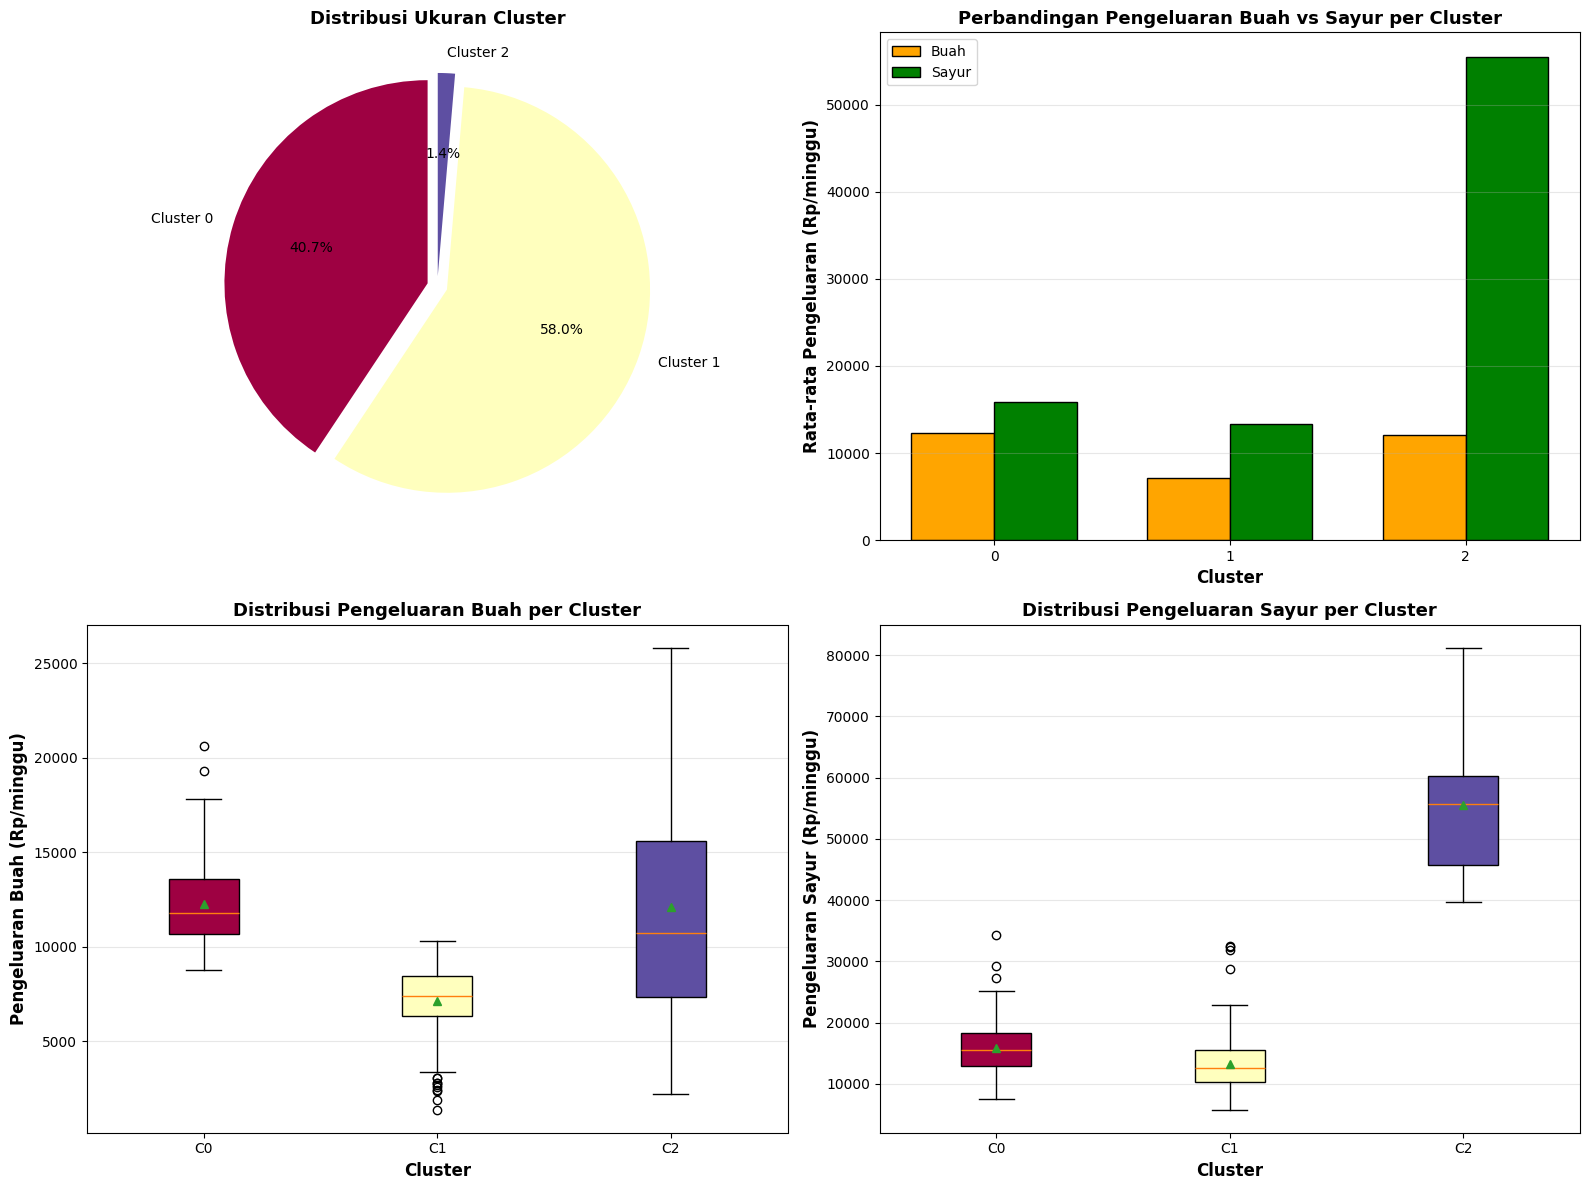

✓ Comparative visualizations complete!


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cluster Size Distribution (Pie Chart)
cluster_sizes = df_plot['Cluster'].value_counts().sort_index()
axes[0, 0].pie(cluster_sizes, labels=[f'Cluster {i}' for i in range(optimal_k)],
               autopct='%1.1f%%', startangle=90, colors=colors, explode=[0.05]*optimal_k)
axes[0, 0].set_title('Distribusi Ukuran Cluster', fontsize=13, fontweight='bold')

# 2. Average Expenditure: Buah vs Sayur per Cluster (Grouped Bar Chart)
buah_per_cluster = []
sayur_per_cluster = []
for cluster in range(optimal_k):
    cluster_data = df_plot[df_plot['Cluster'] == cluster]
    buah_per_cluster.append(cluster_data['Pengeluaran_Buah'].mean())
    sayur_per_cluster.append(cluster_data['Pengeluaran_Sayur'].mean())

x = np.arange(optimal_k)
width = 0.35
axes[0, 1].bar(x - width/2, buah_per_cluster, width, label='Buah', color='orange', edgecolor='black')
axes[0, 1].bar(x + width/2, sayur_per_cluster, width, label='Sayur', color='green', edgecolor='black')
axes[0, 1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Rata-rata Pengeluaran (Rp/minggu)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Perbandingan Pengeluaran Buah vs Sayur per Cluster', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Boxplot: Pengeluaran Buah per Cluster
buah_data = [df_plot[df_plot['Cluster'] == c]['Pengeluaran_Buah'].values for c in range(optimal_k)]
bp1 = axes[1, 0].boxplot(buah_data, labels=[f'C{i}' for i in range(optimal_k)],
                          patch_artist=True, showmeans=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Pengeluaran Buah (Rp/minggu)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Distribusi Pengeluaran Buah per Cluster', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Boxplot: Pengeluaran Sayur per Cluster
sayur_data = [df_plot[df_plot['Cluster'] == c]['Pengeluaran_Sayur'].values for c in range(optimal_k)]
bp2 = axes[1, 1].boxplot(sayur_data, labels=[f'C{i}' for i in range(optimal_k)],
                          patch_artist=True, showmeans=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Pengeluaran Sayur (Rp/minggu)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Distribusi Pengeluaran Sayur per Cluster', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Comparative visualizations complete!")

## 11. Export Results

**Tujuan**: Menyimpan hasil clustering untuk analisis lanjutan.

**File yang di-export**:
1. **clustering_results.csv**: Dataset dengan label cluster
2. **cluster_profiles.csv**: Profil setiap cluster
3. **cluster_centroids.csv**: Nilai centroid setiap cluster

**Kegunaan**:
- Integrasi dengan tools lain (Tableau, PowerBI)
- Dokumentasi hasil
- Analisis lanjutan

In [ ]:
output_dir = Path('data/modeling')
output_dir.mkdir(parents=True, exist_ok=True)

print("Exporting clustering results...")

# 1. Export main results with cluster labels
df_export = df_pivot[['Kabupaten_Kota', 'Tahun', 'Region', 'Pengeluaran_Buah', 'Pengeluaran_Sayur', 'Cluster']].copy()
df_export.to_csv(output_dir / 'clustering_results.csv', index=False)
print(f"✓ Exported: clustering_results.csv ({df_export.shape})")

# 2. Export cluster profiles
cluster_profiles = []
centroids_original = scaler.inverse_transform(kmeans_final.cluster_centers_)

for cluster in range(optimal_k):
    cluster_data = df_pivot[df_pivot['Cluster'] == cluster]
    
    profile = {
        'Cluster': cluster,
        'Size': len(cluster_data),
        'Centroid_Buah': centroids_original[cluster, 0],
        'Centroid_Sayur': centroids_original[cluster, 1],
        'Mean_Buah': cluster_data['Pengeluaran_Buah'].mean(),
        'Mean_Sayur': cluster_data['Pengeluaran_Sayur'].mean(),
        'Median_Buah': cluster_data['Pengeluaran_Buah'].median(),
        'Median_Sayur': cluster_data['Pengeluaran_Sayur'].median(),
        'Std_Buah': cluster_data['Pengeluaran_Buah'].std(),
        'Std_Sayur': cluster_data['Pengeluaran_Sayur'].std(),
        'Silhouette_Score': sample_silhouette_values[cluster_labels == cluster].mean()
    }
    cluster_profiles.append(profile)

profiles_df = pd.DataFrame(cluster_profiles)
profiles_df.to_csv(output_dir / 'cluster_profiles.csv', index=False)
print(f"✓ Exported: cluster_profiles.csv ({profiles_df.shape})")

# 3. Export cluster centroids
centroids_df = pd.DataFrame(centroids_original, columns=feature_cols)
centroids_df.insert(0, 'Cluster', range(optimal_k))
centroids_df.to_csv(output_dir / 'cluster_centroids.csv', index=False)
print(f"✓ Exported: cluster_centroids.csv ({centroids_df.shape})")

print("\n" + "="*60)
print(f"✓ All files exported to: {output_dir.absolute()}")
print("="*60)

Exporting clustering results...
✓ Exported: clustering_results.csv ((514, 6))
✓ Exported: cluster_profiles.csv ((3, 11))
✓ Exported: cluster_centroids.csv ((3, 3))

✓ All files exported to: d:\Perkuliahan\2025-2026\Analisa Big Data\Project Real\data\modeling


---
## 📊 Kesimpulan Modeling

Notebook ini telah menyelesaikan tahapan modeling lengkap **menggunakan data LONG format**:

### Tahapan yang Dilakukan:
1. ✅ **Import Libraries** - Memuat semua library yang diperlukan
2. ✅ **Load Data** - Memuat data long format (`data_integrated_long.csv`)
3. ✅ **Data Preparation** - Filter `Is_Total=True` dan pivot ke semi-wide format
4. ✅ **Feature Scaling** - Normalisasi 2 fitur (Buah & Sayur) menggunakan StandardScaler
5. ✅ **Determine Optimal K** - Menggunakan Elbow Method dan Silhouette Analysis
6. ✅ **Train K-Means** - Melatih model dengan k optimal
7. ✅ **Evaluate Model** - Evaluasi menggunakan Silhouette Score
8. ✅ **Visualize Clusters** - Scatter plot Buah vs Sayur (2D natural, tanpa PCA)
9. ✅ **Cluster Profiling** - Analisis karakteristik setiap cluster berdasarkan Region & Pengeluaran
10. ✅ **Comparative Analysis** - Membandingkan cluster secara visual (Pie, Bar, Boxplot)
11. ✅ **Export Results** - Menyimpan hasil clustering untuk analisis lanjutan

### Output Files:
- `data/modeling/clustering_results.csv` - Label cluster untuk setiap kabupaten/kota
- `data/modeling/cluster_profiles.csv` - Profil statistik setiap cluster (Buah & Sayur)
- `data/modeling/cluster_centroids.csv` - Centroid setiap cluster

### Metode yang Digunakan:
- **Data Source**: Long format → Pivot ke semi-wide (2 fitur agregat)
- **Features**: Pengeluaran_Buah dan Pengeluaran_Sayur (lebih mudah diinterpretasi)
- **Clustering Algorithm**: K-Means Clustering
- **Evaluation Metric**: Silhouette Score
- **Visualization**: Scatter plot 2D (tanpa PCA karena sudah 2 dimensi natural)
- **Feature Scaling**: StandardScaler (z-score normalization)

### Keuntungan Pendekatan Long → Semi-Wide:
✅ Lebih konsisten dengan preprocessing (data utama adalah long format)
✅ Interpretasi lebih mudah (2 fitur vs 43 fitur)
✅ Visualisasi lebih clear (sumbu = fitur asli, bukan principal components)
✅ Profil cluster lebih actionable (Buah vs Sayur, bukan per-komoditas)

---
**Next Steps:** Interpretasi hasil clustering dan pembuatan rekomendasi berdasarkan profil cluster yang ditemukan.